In [5]:
import torchvision
import numpy as np
from typing import Any, Callable, List, Optional, Tuple, Union

class CelebAForGender(torchvision.datasets.CelebA):
    def __init__(self, root: str, split: str = "train", target_type: Union[List[str], str] = "attr", transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False) -> None:
        super().__init__(root, split, target_type, transform, target_transform, download)
    
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        X, meta =  super().__getitem__(index) 
        gender_label = meta[20]

        return X, gender_label



data_path = '/home/zx/nfs/server3/data/'

train_dataset = CelebAForGender(data_path, split='train')
val_dataset = CelebAForGender(data_path, split='valid')
test_dataset = CelebAForGender(data_path, split='test')


print(len(train_dataset), len(val_dataset), len(test_dataset))

KeyboardInterrupt: 

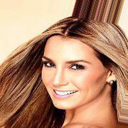

In [ ]:
img, label = train_dataset[0]
img2 = img.resize((128, 128)) w
img2

In [ ]:
import re
def get_name_from_sh(sh_file):
    with open(sh_file) as f:
        for line in f.readlines():
            match = re.search('aug_list=((\d+-){0,2}\d+)', line)
            if match is not None:
                parase = match.group().split('=')[-1]
                yield parase
                    

# g = get_name_from_sh('/home/zx/New_atsp/ATSPrivacy-new/batch_cifar100_5000.sh')
g = get_name_from_sh('batch_vit_cifar100.sh')

GPU=2
Per_GPU=4



for i, c in enumerate(g):
    comm = f'CUDA_VISIBLE_DEVICES={i%GPU} python benchmark/search_transform_attack.py --aug_list={c} --mode=aug --arch=ResNet20-4 --data=CelebA --epochs=2 --num_samples 50 &'
    print(comm)
    if (i+1) % (GPU * Per_GPU) == 0:
        print('wait')

In [ ]:
import os
import torch, torchvision
from torchvision import transforms
from collections import defaultdict
data_path = '/home/zx/'
data_path = os.path.join(data_path, 'imagenet-split-0') if not os.path.exists('/home/zx/nfs/server3/data/imagenet-split-0') else '/home/zx/nfs/server3/data/imagenet-split-0'
trainset = torchvision.datasets.ImageFolder(root=data_path + '/train', transform=transforms.ToTensor())
validset = torchvision.datasets.ImageFolder(root=data_path + '/val', transform=transforms.ToTensor())

sample_list = defaultdict(list)
for idx, (_, label) in enumerate(validset):   
    sample_list[label].append(idx)


In [ ]:
# len([i for i in range(0, len(validset), len(validset)//100)])
import numpy as np
a = np.linspace(0, len(validset), 100, endpoint=False, dtype=np.int16)
sample_list = [int(idx) for idx in a]
for i in sample_list:
    print(i)



In [ ]:
import torch
from collections import defaultdict

identities = dict()
count_id = defaultdict
with open('/home/zx/nfs/server3/data/celeba/identity_CelebA. wtxt') as f:
    lines = f.readlines()
    for line in lines:
        file_name, identity = line.strip().split()
        # identities[file_name] = identity
        count_id[identity] 

print(f'There are {len(set(identities.values()))} identities.')
print(f'There are {len(identities.keys())} images.')

tensor(inf)

: 

In [ ]:
from collections import defaultdict
identities = dict()
count_idx =  defaultdict(int)
with open('/home/zx/nfs/server3/data/celeba/identity_CelebA.txt') as f:
    lines = f.readlines()
    for line in lines:
        file_name, identity = line.strip().split()
        # identities[file_name] = identity
        count_idx[identity] += 1

# print(f'There are {len(set(identities.values()))} identities.')
# print(f'There are {len(identities.keys())} images.')

print(len(count_idx.keys()))

count = list(count_idx.values())

count.sort(reverse=True)
# print(count)
g_30 = filter(lambda x: x==30, count)
print(len(list(g_30)))
# print(type(g_30))

10177
2343


In [ ]:
from pathlib import Path
import os
from shutil import copyfile, copytree

ds_dir = '/home/zx/nfs/server3/data/celeba/identity_dataset/test_full'
count = 0
names = []
for sub_folder in Path(ds_dir).iterdir():
    num_imgs = len(list(sub_folder.iterdir()))
    if num_imgs == 5:
        names.append(sub_folder.name)

data_path =  '/home/zx/nfs/server3/data/celeba/identity_dataset/'
names.sort()
num_classes = 1000

for name in names[:num_classes]:
    #move to train 
    train_dst_path = os.path.join(data_path, 'train')
    train_src_path = os.path.join(data_path, 'train_full')

    if not os.path.exists(train_dst_path):
        os.mkdir(train_dst_path)

    copytree(os.path.join(train_src_path, name), os.path.join(train_dst_path, name), dirs_exist_ok=True)

    # print(os.path.join(train_src_path, name), os.path.join(train_dst_path, name))

    #move to test 
    test_dst_path = os.path.join(data_path, 'test')
    test_src_path = os.path.join(data_path, 'test_full')

    if not os.path.exists(test_dst_path):
        os.mkdir(test_dst_path)

    copytree(os.path.join(test_src_path, name), os.path.join(test_dst_path, name), dirs_exist_ok=True)
    # print(os.path.join(test_src_path, name), os.path.join(test_dst_path, name))




# print(names[:100])
# print(len(names))
        
# print(count


In [ ]:
import torch

a = torch.load('/home/zx/nfs/server3/ATSPrivacy/checkpoints/data_DC_FashionMinist_arch_ConvNet8_embed_mode_DC_auglist__rlabel_False/ConvNet8_1000.pt')

In [ ]:
# print(a.keys())
# for k, v in a.items():
#     print(k.partition('module.')[2])
#     break
# state_dict = {k.partition('module.')[2]: v for k,v in a.items()}


state_dict = a
torch.save(state_dict, '/home/zx/nfs/server3/ATSPrivacy/checkpoints/data_DC_FashionMinist_arch_ConvNet8_embed_mode_DC_auglist__rlabel_False/ConvNet8_embed_1000.pth')

## plot psnr

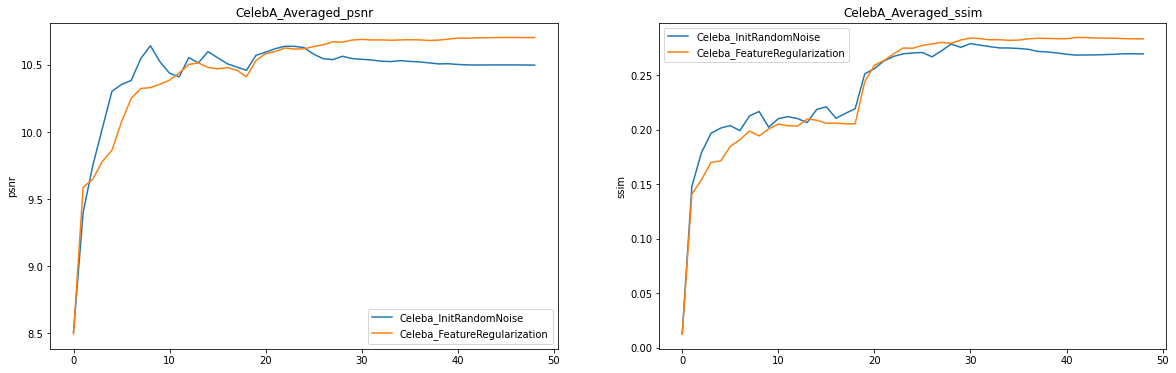

In [7]:

import utils_img
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import lpips
import torchvision, torch
import os
import natsort

def draw_metric(method='psnr',reconstructed_imgs_path=None, origin_imgs_path=None, label='', plot=True):

    ori_img = np.array(Image.open(origin_imgs_path))
    metric_list = []

    if method == 'lpips':
        loss_fn = lpips.LPIPS(net='alex')
        
    for img_path in reconstructed_imgs_path:
        rec_img = np.array(Image.open(img_path))
        if method == 'psnr':
            metric_list.append(utils_img.calculate_psnr(ori_img, rec_img))       
        elif method == 'ssim':
            metric_list.append(utils_img.calculate_ssim(ori_img, rec_img))       
        elif method == 'lpips':
            ori_img_th = torchvision.io.read_image(origin_imgs_path).to(dtype=torch.float32)
            rec_img_th = torchvision.io.read_image(img_path).to(dtype=torch.float32)

            ori_img_th = (ori_img_th -128 )/128
            rec_img_th = (rec_img_th - 128) /128
            score = loss_fn(ori_img_th.unsqueeze(0), rec_img_th.unsqueeze(0)).detach().item()
            metric_list.append(score)
        elif method == 'mse':
            
            ori_img_th = torchvision.io.read_image(origin_imgs_path).to(dtype=torch.float32)
            rec_img_th = torchvision.io.read_image(img_path).to(dtype=torch.float32)

            mse_score = (ori_img_th - rec_img_th).pow(2).mean(dim=[1, 2, 3])
            avg_mse, max_mse = mse_score.mean().item(), mse_score.max().item()
            metric_list.append(avg_mse)
        else:
            raise NotImplementedError(f'The method of {method} not implemented yet.')
            
            
    # plt.figure()
    if plot:
        plt.plot(range(len(metric_list)), metric_list, label=label)
        plt.ylabel(method)
    # plt.legend(legend)
    
    return metric_list
    

# draw single idx for different methods
"""
idxs = range(1,5) 
for idx in idxs:
    plt.figure()
    origin_imgs_path = f'/home/zx/nfs/server3/ATSPrivacy/benchmark/images/data_CelebA_Gender_arch_ResNet18_tv_epoch_2_optim_inversed_large_mode_normal_auglist__rlabel_False_verbose/ori_{idx}.png'
    
    reconstructed_imgs_path = natsort.os_sorted(utils_img.get_image_paths(f'/home/zx/nfs/server3/ATSPrivacy/benchmark/images/data_CelebA_Gender_arch_ResNet18_tv_epoch_2_optim_inversed_large_mode_normal_auglist__rlabel_False_verbose/{idx}'))
    # print(reconstructed_imgs_path)
    # break
    draw_metric(method=method, reconstructed_imgs_path=reconstructed_imgs_path, origin_imgs_path=origin_imgs_path, label='celeba')
    plt.title(f'{idx}') 
    plt.legend()
"""  

#draw average figure for method

def draw_aveage_metric(idxs, result_imgs_dir, method):
    metric_lists = []
    for idx in idxs:
        # break
        origin_imgs_path = os.path.join(result_imgs_dir, f"ori_{idx}.png")
        reconstructed_imgs_path = natsort.os_sorted(utils_img.get_image_paths(os.path.join(result_imgs_dir, f"{idx}")))

        metric_lists.append(draw_metric(method=method, reconstructed_imgs_path=reconstructed_imgs_path, origin_imgs_path=origin_imgs_path, label=None, plot=False))
        
    average_metric = np.mean(metric_lists, axis=0)

    return average_metric

# method = "lpips" 
# methods = ["psnr", "ssim", "lpips"]

# plt.figure(figsize=(10*len(methods), 6))
# for i,method in enumerate(methods):

#     idxs = [3, 9 , 14, 18, 20, 22, 23, 25, 29, 30, 31] 
#     result_imgs_dir = f'/home/zx/nfs/server3/ATSPrivacy/benchmark/images/data_CelebA_Gender_arch_ResNet18_tv_epoch_2_optim_inversed_large_mode_normal_auglist__rlabel_False_verbose'
#     average_metric = draw_aveage_metric(idxs=idxs, result_imgs_dir=result_imgs_dir, method=method)
#     plt.subplot(1, len(methods), i+1)
#     plt.plot(range(len(average_metric)), average_metric, label="Celeba_InitRandomNoise")



#     metric_lists = []
#     result_imgs_dir = f'/home/zx/nfs/server3/ATSPrivacy/benchmark/images/data_CelebA_Gender_arch_ResNet18_tv_epoch_2_optim_inversed_large_mode_normal_auglist__rlabel_False_verbose_initSameAttr'
#     average_metric = draw_aveage_metric(idxs=idxs, result_imgs_dir=result_imgs_dir, method=method)
#     plt.subplot(1, len(methods), i+1)
#     plt.plot(range(len(average_metric)), average_metric, label="Celeba_InitSameAttr")


#     plt.ylabel(method)
#     plt.title(f"CelebA_Averaged_{method}") 
#     plt.legend()
# # plt.savefig(f"./fig/celeba.pdf", dpi=600)
#     # break

methods = ["psnr", "ssim"]    
plt.figure(figsize=(10*len(methods), 6))
for i, method in enumerate(methods):
    idxs = [1,2,3,4,5]
    result_imgs_dir = "/home/zx/nfs/server3/ATSPrivacy/scale_CelebAHQ_Gender/data_CelebAHQ_Gender_arch_ResNet18_tv_epoch_3_optim_inversed_large_mode_normal_auglist__rlabel_False_224_verbose"
    average_metric = draw_aveage_metric(idxs=idxs, result_imgs_dir=result_imgs_dir, method=method)
    plt.subplot(1, len(methods), i+1)
    plt.plot(range(len(average_metric)), average_metric, label="Celeba_InitRandomNoise")
    
    
    metric_lists = [] 
    result_imgs_dir = f"/home/zx/nfs/server3/ATSPrivacy/benchmark/images/data_CelebAHQ_Gender_arch_ResNet18_tv_epoch_3_optim_inversed_large_mode_normal_auglist__rlabel_False"
    average_metric = draw_aveage_metric(idxs=idxs, result_imgs_dir=result_imgs_dir, method=method)
    plt.subplot(1, len(methods), i+1)
    plt.plot(range(len(average_metric)), average_metric, label="Celeba_FeatureRegularization")

    plt.ylabel(method)
    plt.title(f"CelebA_Averaged_{method}") 
    plt.legend()

In [5]:
import torch
total_loss = torch.load("/home/zx/nfs/server3/ATSPrivacy/total_loss.pt")
torch.mean(total_loss, dim=0)

tensor([0.1204, 0.1537, 0.2690, 0.2042, 0.2309, 0.3109, 0.2182, 0.2583, 0.2904,
        0.2212, 0.2476, 0.3031, 0.2039, 0.2739, 0.2817, 0.2054, 0.2320, 0.2833,
        0.1945, 0.2368, 0.2711, 0.1804, 0.2447, 0.2711, 0.1949, 0.2166, 0.2709,
        0.1663, 0.2432, 0.2550, 0.1635, 0.2002, 0.2601, 0.1361, 0.1977, 0.2128,
        0.1237, 0.2099, 0.2128, 0.1340, 0.1809, 0.2161, 0.0945, 0.1923, 0.1790,
        0.0859, 0.1516, 0.1788, 0.0673, 0.1523, 0.1548, 0.0469, 0.1697, 0.1548,
        0.0597, 0.1381, 0.1548, 0.0268, 0.1590, 0.1449, 0.0038, 0.1094],
       device='cuda:0')

In [2]:
import torch
g_112 = torch.load("/home/zx/nfs/server3/ATSPrivacy/gradients_in_diff_imgsize/112", map_location=torch.device("cpu"))
g_224 = torch.load("/home/zx/nfs/server3/ATSPrivacy/gradients_in_diff_imgsize/224", map_location=torch.device("cpu"))
print(g_224[0][0])

tensor([[[[-3.4117e-04, -3.7162e-04, -3.7106e-04,  ..., -1.2549e-04,
           -4.9381e-05, -1.5916e-05],
          [-5.5163e-04, -5.1815e-04, -5.2497e-04,  ..., -4.5056e-04,
           -4.2215e-04, -3.9082e-04],
          [-7.3670e-04, -6.8690e-04, -6.7506e-04,  ..., -6.3494e-04,
           -6.1409e-04, -6.5610e-04],
          ...,
          [-1.0370e-03, -9.6960e-04, -1.0302e-03,  ..., -9.1668e-04,
           -8.3569e-04, -9.4034e-04],
          [-1.0323e-03, -9.3349e-04, -1.0117e-03,  ..., -9.6889e-04,
           -8.8225e-04, -9.3287e-04],
          [-9.9024e-04, -9.2871e-04, -9.4697e-04,  ..., -9.0175e-04,
           -9.8954e-04, -1.0012e-03]],

         [[-8.4398e-05, -1.4671e-04, -1.7061e-04,  ...,  8.1017e-05,
            1.8941e-04,  2.0494e-04],
          [-2.5927e-04, -2.5121e-04, -2.8200e-04,  ..., -2.0887e-04,
           -1.5420e-04, -1.2345e-04],
          [-4.2663e-04, -3.8596e-04, -3.9400e-04,  ..., -3.4790e-04,
           -3.0149e-04, -3.5535e-04],
          ...,
     

In [2]:
import torch
a = torch.randn((3,7,7))
label = torch.tensor(0)
a[label] != 0

tensor([[True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True]])